## Imports

In [33]:
# Data/text Manipulation
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Models
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
# Support Vector Machine Classifier
from sklearn import svm
# Recurrent Neural Network (keras)
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Scoring the models
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Looking at the confusion matrix/RNN accuracy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Data

Dataset comes from kaggle: https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [2]:
data = pd.read_csv("spam.csv", encoding = 'latin-1',usecols=[0,1])
data.columns=['target','text']
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preprocessing

In [3]:
print("We have "+str(len(data['text']))+" messages total in our dataset.")

We have 5572 messages total in our dataset.


Before we begin trying different models, we need to preprocess our messages to read them into the models. First we remove all punctuation. Next we'll coerce all the words to lowercase. We'll then lemmatize the words. Then we can create count vectors for each document using scikitlearn's count vectorizer.

In [5]:
data['text'] = data['text'].apply(lambda a: re.sub(r'[^\w\s]','',a))
data['text'] = data['text'].apply(lambda a: a.lower())
lemmatizer = WordNetLemmatizer()
def cleanLemma(message):
    words = [lemmatizer.lemmatize(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    return " ".join(words)
data['text'] = data['text'].apply(cleanLemma)

In [6]:
data['text'][0:5]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: text, dtype: object

In [7]:
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
features = cv.fit_transform(data['text'])

This is what our features now look like.

In [8]:
word_freq_df = pd.DataFrame(features.toarray(), columns=cv.get_feature_names())
word_freq_df.head()

,0089my,0776xxxxxxx,077xxx,0789xxxxxxx,0796xxxxxx,07xxxxxxxxx,08452810075over18s,08700621170150p,08701417012150p,08702840625comuk,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Okay so now we have our features encoded as vectors. Next we will encode our target variable - either spam or the opposite of spam, 'ham', using one-hot encoding.

In [9]:
def encode(target):
    if target == 'spam':
        return 1
    else:
        return 0
data['target'] = data['target'].apply(encode)

Now we'll split our data into testing and training data.

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(features, data['target'], stratify = data['target'], test_size = 0.15)

Now that we have our features and our target clearly defined, we will try three different models for predicting whether a message is spam or not. We'll build a naive bayes classifier, a support vector machine, and a simple recurrent neural network.

## Naive Bayes Classifier

In [11]:
naive_bayes = MultinomialNB()
naive_bayes.fit(xtrain, ytrain)
nb_predictions = naive_bayes.predict(xtest)

In [12]:
print('Accuracy score: ', accuracy_score(ytest, nb_predictions))
print('Precision score: ', precision_score(ytest, nb_predictions))
print('Recall score: ', recall_score(ytest, nb_predictions))

Accuracy score:  0.9688995215311005
Precision score:  0.8412698412698413
Recall score:  0.9464285714285714


Text(91.68, 0.5, 'predicted label')

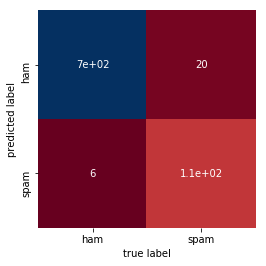

In [13]:
cm = confusion_matrix(ytest, nb_predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('true label')
plt.ylabel('predicted label')

With Naive Bayes we were fairly accurate though not quite as precise. We incorrectly labeled 20 spam messages as ham. 

## Support Vector Machine Classifier

In [14]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(xtrain,ytrain)
svm_predictions = SVM.predict(xtest)

In [15]:
print('Accuracy score: ', accuracy_score(ytest, svm_predictions))
print('Precision score: ', precision_score(ytest, svm_predictions))
print('Recall score: ', recall_score(ytest, svm_predictions))

Accuracy score:  0.9808612440191388
Precision score:  0.98
Recall score:  0.875


Text(91.68, 0.5, 'predicted label')

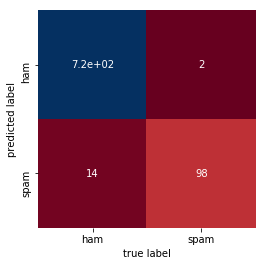

In [16]:
cm = confusion_matrix(ytest, svm_predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('true label')
plt.ylabel('predicted label')

With an SVM classifier we were able to acheive higher levels of accuracy and precision, though our recall was much lower. We incorrectly labeled 14 real messages as spam - not great if these were important business emails.

## Simple Recurrent Neural Network for Classification

In [17]:
# create the model
model = Sequential()
model.add(Embedding(8177, 100, input_length=8177))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8177, 100)         817700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 898,201
Trainable params: 898,201
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=3, batch_size=64)

/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/3
4736/4736 [==============================] - 2878s 608ms/step - loss: 0.4199 - accuracy: 0.8659 - val_loss: 0.3944 - val_accuracy: 0.8660
Epoch 2/3
4736/4736 [==============================] - 3020s 638ms/step - loss: 0.3955 - accuracy: 0.8659 - val_loss: 0.3947 - val_accuracy: 0.8660
Epoch 3/3
4736/4736 [==============================] - 3245s 685ms/step - loss: 0.3939 - accuracy: 0.8659 - val_loss: 0.3985 - val_accuracy: 0.8660


In [20]:
rnn_predictions = model.predict(xtest)

In [27]:
loss, accuracy = model.evaluate(xtest, ytest, verbose=0)

In [28]:
model.metrics_names

['loss', 'accuracy']

In [30]:
print('Accuracy score: ', accuracy)
print('Loss: ', loss)

Accuracy score:  0.8660287261009216
Loss:  0.3984638318490754


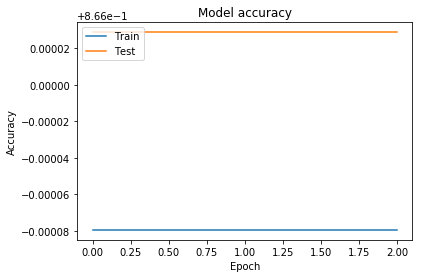

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Here we see that, partially because we didn't train it for more than 3 epochs, the accuracy wasn't really improved in the training stages.

## Conclusion and Next Steps

Of the three models we ran, the SVM had the highest accuracy and precision. Very few real messages were blocked due by the spam filter, while only a few spam messages were allowed through. The neural net was the worst of the three, but I can see that being a product of the limited training and also of the simplistic method of vectorization. If we were to use something less sparse, such as GloVe or even just tf-idf, we'd probably be able to train the RNN to outperform the other two models. However, the simplicity and training time of the SVM and NB classifiers are huge benefits for a simple program to classify ham vs spam messages. 